<a href="https://colab.research.google.com/github/Sonica-B/Computer-Vision-CS-549/blob/HW0/HW0/ssboyane_hw0/HW0Phase1AndPhase2Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RBE/CS549 Fall 2022: Computer Vision
## Homework 0: Alohomora

Author(s):
Prof. Nitin J. Sanket (nsanket@wpi.edu), Lening Li (lli4@wpi.edu), Gejji, Vaishnavi Vivek (vgejji@wpi.edu)

Robotics Engineering Department,

Worcester Polytechnic Institute

Code adapted from CMSC733 at the University of Maryland, College Park.


## Phase 1




### Get the BSDS500 dataset

In [1]:
!wget https://raw.githubusercontent.com/leelening/rbe549/main/hw0/BSDS500.tar.xz
!tar -xvf BSDS500.tar.xz
!mv BSDS500/ /content/data/

--2025-01-10 22:31:17--  https://raw.githubusercontent.com/leelening/rbe549/main/hw0/BSDS500.tar.xz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 812060 (793K) [application/octet-stream]
Saving to: ‘BSDS500.tar.xz’

BSDS500.tar.xz      100%[===================>] 793.03K  --.-KB/s    in 0.04s   

2025-01-10 22:31:18 (20.7 MB/s) - ‘BSDS500.tar.xz’ saved [812060/812060]

BSDS500/
BSDS500/CannyBaseline/
BSDS500/CannyBaseline/1.png
BSDS500/CannyBaseline/10.png
BSDS500/CannyBaseline/2.png
BSDS500/CannyBaseline/3.png
BSDS500/CannyBaseline/4.png
BSDS500/CannyBaseline/5.png
BSDS500/CannyBaseline/6.png
BSDS500/CannyBaseline/7.png
BSDS500/CannyBaseline/8.png
BSDS500/CannyBaseline/9.png
BSDS500/GroundTruth/
BSDS500/GroundTruth/1.png
BSDS500/GroundTruth/10.png
BSDS500/

In [2]:
!wget https://raw.githubusercontent.com/leelening/rbe549/main/hw0/TxtFiles.tar.xz
!tar -xvf TxtFiles.tar.xz
!mv TxtFiles/ /content/data/

--2025-01-10 22:31:21--  https://raw.githubusercontent.com/leelening/rbe549/main/hw0/TxtFiles.tar.xz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 55376 (54K) [application/octet-stream]
Saving to: ‘TxtFiles.tar.xz’

TxtFiles.tar.xz     100%[===================>]  54.08K  --.-KB/s    in 0.009s  

2025-01-10 22:31:21 (6.17 MB/s) - ‘TxtFiles.tar.xz’ saved [55376/55376]

TxtFiles/
TxtFiles/DirNamesTest.txt
TxtFiles/DirNamesTrain.txt
TxtFiles/LabelsTest.txt
TxtFiles/LabelsTrain.txt


In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [ ]:
class FilterUtils:
    """Base utilities for all filter types"""


    def create_gaussian_kernel(size, sigma_x, sigma_y=None):
        """
        Creates a 2D Gaussian kernel with optional different sigmas for x and y

        Args:
            size: Kernel size (must be odd)
            sigma_x: Standard deviation in x direction
            sigma_y: Standard deviation in y direction (if None, uses sigma_x)

        Returns:
            2D Gaussian kernel normalized to sum to 1
        """
        size = int(size)
        if size % 2 == 0:
            size += 1  # Ensure odd size

        if sigma_y is None:
            sigma_y = sigma_x

        # Create coordinate grid
        halfsize = size // 2
        x = np.linspace(-halfsize, halfsize, size)
        y = np.linspace(-halfsize, halfsize, size)
        X, Y = np.meshgrid(x, y)

        # Calculate Gaussian values
        gaussian = np.exp(-(X**2 / (2*sigma_x**2) + Y**2 / (2*sigma_y**2)))

        # Normalize
        return gaussian / gaussian.sum()


    def rotate_kernel(kernel, angle_degrees):
        """
        Rotates a kernel by the specified angle using cv2

        Args:
            kernel: Input kernel to rotate
            angle_degrees: Rotation angle in degrees

        Returns:
            Rotated kernel
        """
        rows, cols = kernel.shape
        M = cv2.getRotationMatrix2D((cols/2, rows/2), angle_degrees, 1)
        rotated = cv2.warpAffine(kernel, M, (cols, rows))
        return rotated


    def normalize_kernel(kernel):
        """
        Normalizes a kernel to ensure it sums to 0 (for derivative filters)
        or 1 (for smoothing filters)

        Args:
            kernel: Input kernel

        Returns:
            Normalized kernel
        """
        if np.abs(kernel.sum()) < 1e-10:  # Derivative filter
            return kernel / np.abs(kernel).sum()
        else:  # Smoothing filter
            return kernel / kernel.sum()

1. Generate Difference of Gaussian Filter Bank: (DoG)
2. Display all the filters in this filter bank and save image as DoG.png,
3. use command "cv2.imwrite(...)"

In [2]:
####  TEST2
#from filter_utils import FilterUtils

class DoGFilter:
    """Derivative of Gaussian Filter Implementation"""

    def __init__(self):
        self.utils = FilterUtils()

    def generate_filters(self, scales=2, orientations=16):
        """
        Generates Derivative of Gaussian filters at multiple scales and orientations

        Args:
            scales: Number of scales
            orientations: Number of orientations

        Returns:
            List of DoG filters
        """
        filters = []

        # Base Sobel kernel for x-direction
        sobel_x = np.array([[-1, 0, 1],
                           [-2, 0, 2],
                           [-1, 0, 1]])

        for scale in range(scales):
            # Calculate sigma and kernel size for this scale
            sigma = 2 ** scale
            size = int(6 * sigma)  # 6 sigma rule for kernel size

            # Generate Gaussian kernel
            gaussian = self.utils.create_gaussian_kernel(size, sigma)

            # Generate oriented filters for this scale
            for theta in np.linspace(0, 180, orientations, endpoint=False):
                # Rotate Sobel kernel
                rotated_sobel = self.utils.rotate_kernel(sobel_x, theta)

                # Convolve Gaussian with rotated Sobel
                dog = cv2.filter2D(gaussian, -1, rotated_sobel)
                dog = self.utils.normalize_kernel(dog)

                filters.append(dog)

        return filters

In [1]:
####  TEST1

# Function to create Gaussian kernel
def gaussian_kernel(size, sigma):
    ax = np.linspace(-(size // 2), size // 2, size)
    x, y = np.meshgrid(ax, ax)
    kernel = np.exp(-(x**2 + y**2) / (2 * sigma**2))
    return kernel / kernel.sum()

# Function to create Sobel operators
def sobel_filters():
    sobel_x = np.array([[-1, 0, 1],
                        [-2, 0, 2],
                        [-1, 0, 1]])
    sobel_y = np.array([[1, 2, 1],
                        [0, 0, 0],
                        [-1, -2, -1]])
    return sobel_x, sobel_y

# Function to rotate a filter by a given angle
def rotate_filter(filter, angle):
    size = filter.shape[0]
    center = size // 2
    rotation_matrix = cv2.getRotationMatrix2D((center, center), angle, 1)
    rotated_filter = cv2.warpAffine(filter, rotation_matrix, (size, size))
    return rotated_filter

# Function to generate the DoG filter bank
def generate_dog_filter_bank(scales, orientations):
    filters = []
    sobel_x, sobel_y = sobel_filters()

    for scale in scales:
        # Generate Gaussian kernel
        size = int(scale * 6)  # Kernel size proportional to scale
        if size % 2 == 0:  # Ensure odd size
            size += 1
        gaussian = gaussian_kernel(size, scale)

        # Compute Derivatives of Gaussian (DoG)
        dog_x = np.convolve(gaussian.flatten(), sobel_x.flatten(), mode='same').reshape(size, size)
        dog_y = np.convolve(gaussian.flatten(), sobel_y.flatten(), mode='same').reshape(size, size)

        # Rotate DoG filters to generate orientations
        for orientation in range(orientations):
            angle = (360 / orientations) * orientation
            rotated_x = rotate_filter(dog_x, angle)
            rotated_y = rotate_filter(dog_y, angle)
            filters.append(rotated_x + rotated_y)  # Combine x and y derivatives

    return filters

# Parameters
scales = [2, 4]  # Two scales
orientations = 16  # 16 orientations

# Generate filter bank
dog_filter_bank = generate_dog_filter_bank(scales, orientations)

# Display the filter bank
rows = len(scales)
cols = orientations
fig, axes = plt.subplots(rows, cols, figsize=(15, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(dog_filter_bank[i], cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

# Save the filter bank as an image
dog_image = np.zeros((rows * 31, cols * 31))  # Assuming filter size is 31x31
for i in range(rows):
    for j in range(cols):
        filter_resized = cv2.resize(dog_filter_bank[i * cols + j], (31, 31))
        dog_image[i * 31:(i + 1) * 31, j * 31:(j + 1) * 31] = filter_resized

cv2.imwrite("DoG_Filter_Bank.png", (dog_image * 255).astype(np.uint8))
print("DoG filter bank saved as 'DoG_Filter_Bank.png'")


NameError: name 'np' is not defined


1. Generate Leung-Malik Filter Bank: (LM)
2. Display all the filters in this filter bank and save image as LM.png,
3. use command "cv2.imwrite(...)"


In [3]:
### TEST2

class LMFilter:
    """Leung-Malik Filter Implementation"""

    def __init__(self):
        self.utils = FilterUtils()

    def generate_filters(self, small_scale=True):
        """
        Generates Leung-Malik filter bank

        Args:
            small_scale: If True, generates LMS, else LML

        Returns:
            List of LM filters
        """
        filters = []

        # Define scales based on filter type
        if small_scale:
            scales = [1, np.sqrt(2), 2, 2*np.sqrt(2)]  # LMS
        else:
            scales = [np.sqrt(2), 2, 2*np.sqrt(2), 4]  # LML

        # Generate first and second derivative filters
        orientations = 6
        elongation = 3  # Elongation factor

        for scale in scales[:3]:  # First 3 scales for derivatives
            sigma = scale
            size = int(6 * sigma * elongation)

            for theta in np.linspace(0, 180, orientations, endpoint=False):
                # First derivative
                kernel_1st = self._create_derivative_kernel(size, sigma,
                                                          elongation, theta, order=1)
                filters.append(kernel_1st)

                # Second derivative
                kernel_2nd = self._create_derivative_kernel(size, sigma,
                                                          elongation, theta, order=2)
                filters.append(kernel_2nd)

        # Generate Gaussian and LoG filters
        for scale in scales:
            size = int(6 * scale)

            # Gaussian
            gaussian = self.utils.create_gaussian_kernel(size, scale)
            filters.append(gaussian)

            # Laplacian of Gaussian
            log = self._create_log_kernel(size, scale)
            filters.append(log)

        return filters

    def _create_derivative_kernel(self, size, sigma, elongation, theta, order):
        """Helper method to create derivative kernels"""
        sigma_y = sigma * elongation
        kernel = self.utils.create_gaussian_kernel(size, sigma, sigma_y)

        # Create coordinate grid
        x = np.linspace(-size//2, size//2, size)
        y = np.linspace(-size//2, size//2, size)
        X, Y = np.meshgrid(x, y)

        # Rotate coordinates
        theta_rad = np.deg2rad(theta)
        Xr = X*np.cos(theta_rad) + Y*np.sin(theta_rad)

        # Apply derivative
        if order == 1:
            kernel = kernel * (-Xr/(sigma**2))
        else:  # order == 2
            kernel = kernel * ((Xr**2/sigma**4) - 1/sigma**2)

        return self.utils.normalize_kernel(kernel)

    def _create_log_kernel(self, size, sigma):
        """Helper method to create LoG kernel"""
        x = np.linspace(-size//2, size//2, size)
        y = np.linspace(-size//2, size//2, size)
        X, Y = np.meshgrid(x, y)
        R2 = X**2 + Y**2

        # LoG equation
        gaussian = self.utils.create_gaussian_kernel(size, sigma)
        log = -1/(np.pi*sigma**4) * (1 - R2/(2*sigma**2)) * gaussian

        return self.utils.normalize_kernel(log)

Leung-Malik filter bank saved as 'LM.png'


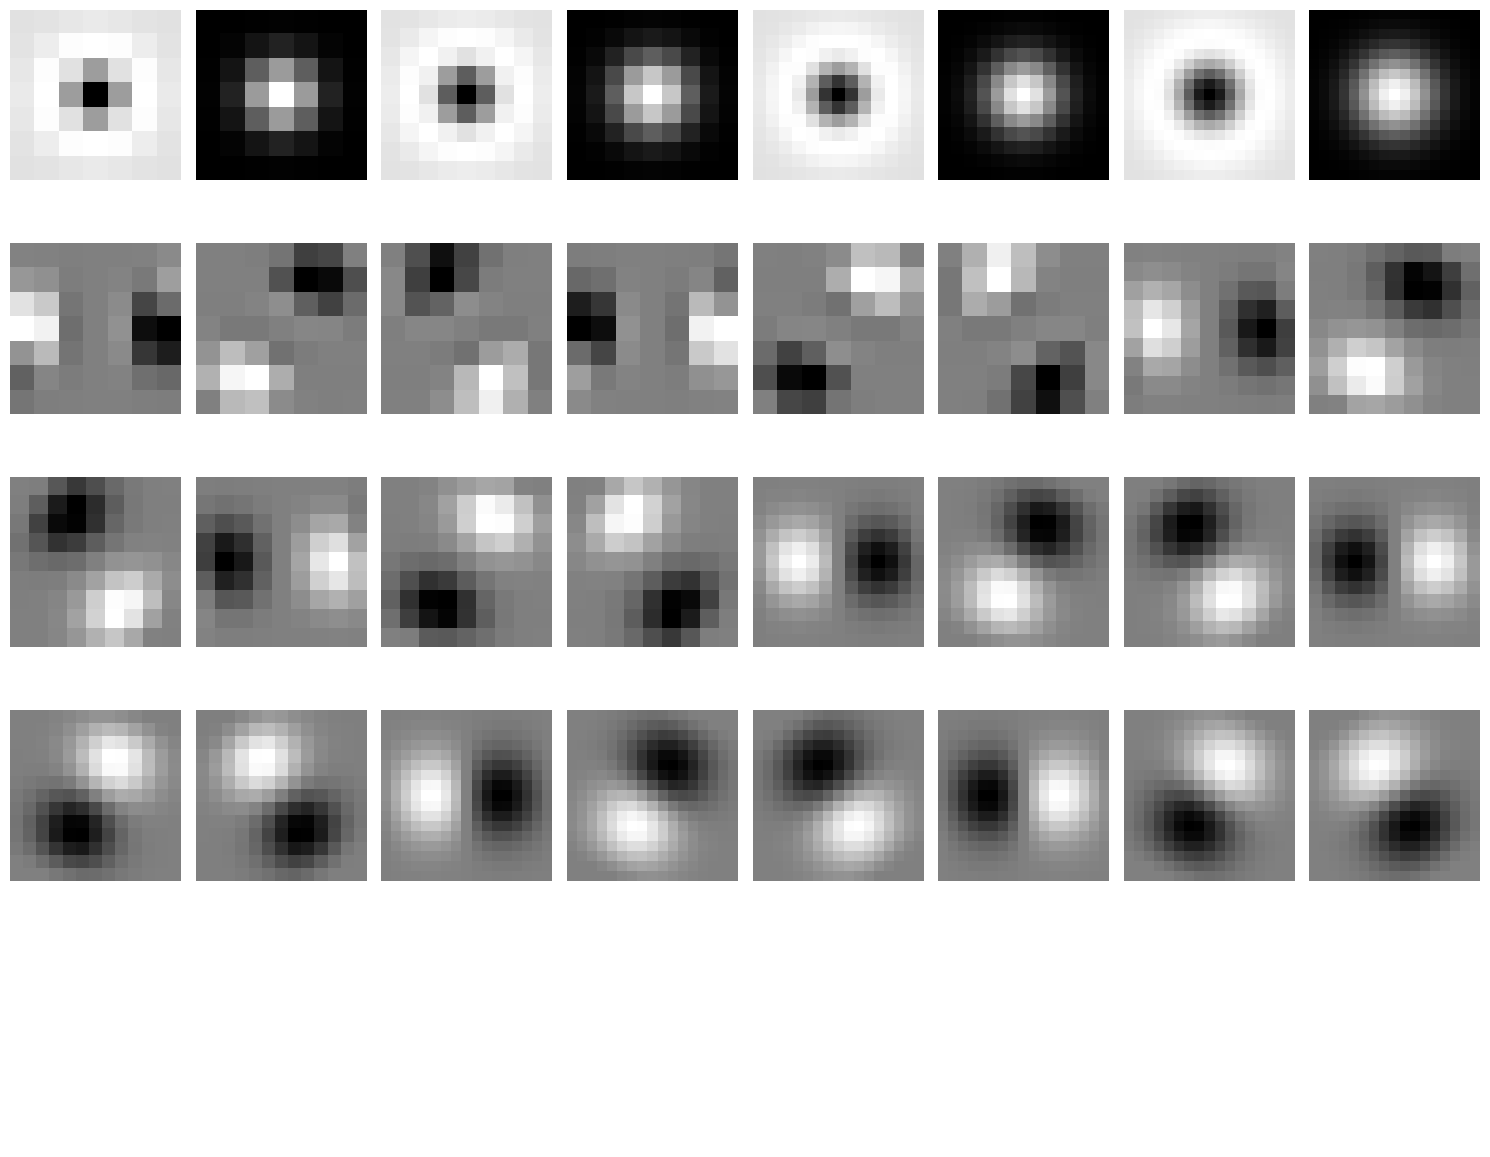

In [6]:
### TEST1

# Function to create Laplacian of Gaussian (LoG) kernel
def laplacian_of_gaussian(size, sigma):
    ax = np.linspace(-(size // 2), size // 2, size)
    x, y = np.meshgrid(ax, ax)
    log = -1 / (np.pi * sigma**4) * (1 - (x**2 + y**2) / (2 * sigma**2)) * np.exp(-(x**2 + y**2) / (2 * sigma**2))
    return log

# Function to generate LM filter bank
def generate_lm_filter_bank(scales, orientations):
    filters = []

    for sigma in scales:
        size = int(sigma * 6)
        if size % 2 == 0:
            size += 1

        # Laplacian of Gaussian (LoG)
        log = laplacian_of_gaussian(size, sigma)
        filters.append(log)

        # Gaussian
        g = gaussian_kernel(size, sigma)
        filters.append(g)

    # Add DoG filters
    dog_filters = generate_dog_filter_bank(scales, orientations)
    filters.extend(dog_filters)

    return filters

# Parameters for LM filter bank
lm_scales = [1, np.sqrt(2), 2, 2 * np.sqrt(2)]  # σ = {1, sqrt(2), 2, 2sqrt(2)}
orientations = 6  # 6 orientations

# Generate LM filter bank
lm_filter_bank = generate_lm_filter_bank(lm_scales, orientations)

# Display and save LM filter bank
rows = len(lm_scales) + 1  # Additional row for DoG filters
cols = orientations + 2  # LoG + Gaussian + orientations
fig, axes = plt.subplots(rows, cols, figsize=(15, 12))
for i, ax in enumerate(axes.flat):
    if i < len(lm_filter_bank):
        ax.imshow(lm_filter_bank[i], cmap='gray')
    ax.axis('off')
plt.tight_layout()

# Save the filter bank as an image
lm_image = np.zeros((rows * 31, cols * 31))  # Assuming filter size is 31x31
for i in range(rows):
    for j in range(cols):
        idx = i * cols + j
        if idx < len(lm_filter_bank):
            filter_resized = cv2.resize(lm_filter_bank[idx], (31, 31))
            lm_image[i * 31:(i + 1) * 31, j * 31:(j + 1) * 31] = filter_resized

cv2.imwrite("LM.png", (lm_image * 255).astype(np.uint8))
print("Leung-Malik filter bank saved as 'LM.png'")

1. Generate Gabor Filter Bank: (Gabor)
2. Display all the filters in this filter bank and save image as Gabor.png,
3. use command "cv2.imwrite(...)"


In [ ]:
### TEST2

class GaborFilter:
    """Gabor Filter Implementation"""

    def __init__(self):
        self.utils = FilterUtils()

    def generate_filters(self, scales=4, orientations=8):
        """
        Generates Gabor filters at multiple scales and orientations

        Args:
            scales: Number of scales
            orientations: Number of orientations

        Returns:
            List of Gabor filters
        """
        filters = []

        # Calculate wavelengths for each scale
        wavelengths = [np.pi * (2**i) for i in range(scales)]
        sigma_ratio = 0.56  # Empirically determined ratio

        for wavelength in wavelengths:
            sigma = wavelength * sigma_ratio
            size = int(6 * sigma)  # 6 sigma rule

            # Generate filters for different orientations
            for theta in np.linspace(0, np.pi, orientations, endpoint=False):
                kernel = self._create_gabor_kernel(size, sigma, wavelength, theta)
                filters.append(kernel)

                # Add phase-shifted version (complex part)
                kernel_shifted = self._create_gabor_kernel(size, sigma, wavelength,
                                                         theta, phase_shift=np.pi/2)
                filters.append(kernel_shifted)

        return filters

    def _create_gabor_kernel(self, size, sigma, wavelength, theta, phase_shift=0):
        """Helper method to create a single Gabor filter"""
        x = np.linspace(-size//2, size//2, size)
        y = np.linspace(-size//2, size//2, size)
        X, Y = np.meshgrid(x, y)

        # Rotate coordinates
        Xr = X*np.cos(theta) + Y*np.sin(theta)
        Yr = -X*np.sin(theta) + Y*np.cos(theta)

        # Create Gabor filter
        gaussian = np.exp(-(Xr**2 + Yr**2)/(2*sigma**2))
        sinusoid = np.cos(2*np.pi*Xr/wavelength + phase_shift)
        kernel = gaussian * sinusoid

        return self.utils.normalize_kernel(kernel)

1. Generate Half-disk masks
2. Display all the Half-disk masks and save image as HDMasks.png,
3. use command "cv2.imwrite(...)"

1. Generate Texton Map
2. Filter image using oriented gaussian filter bank


1. Generate texture ID's using K-means clustering
2. Display texton map and save image as TextonMap_ImageName.png,
3. use command "cv2.imwrite('...)"


1. Generate Texton Gradient (Tg)
2. Perform Chi-square calculation on Texton Map
3. Display Tg and save image as Tg_ImageName.png,
4. use command "cv2.imwrite(...)"


1. Generate Brightness Map
2. Perform brightness binning


1. Generate Brightness Gradient (Bg)
2. Perform Chi-square calculation on Brightness Map
3. Display Bg and save image as Bg_ImageName.png,
4. use command "cv2.imwrite(...)"



1. Generate Color Map
2. Perform color binning or clustering





1. Generate Color Gradient (Cg)
2. Perform Chi-square calculation on Color Map
3. Display Cg and save image as Cg_ImageName.png,
4. use command "cv2.imwrite(...)"




1. Read Sobel Baseline
2. use command "cv2.imread(...)"





1. Read Canny Baseline
2. use command "cv2.imread(...)"





1. Combine responses to get pb-lite output
2. Display PbLite and save image as PbLite_ImageName.png
3. use command "cv2.imwrite(...)"



## Phase 2

### Neural Network Construction

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def loss_fn(out, labels):
    ###############################################
    # Fill your loss function of choice here!
    ###############################################
    loss = ...
    return loss

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = loss_fn(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = loss_fn(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'loss': loss.detach(), 'acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'loss': epoch_loss.item(), 'acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], loss: {:.4f}, acc: {:.4f}".format(epoch, result['loss'], result['acc']))



class CIFAR10Model(ImageClassificationBase):
  def __init__(self, InputSize, OutputSize):
      """
      Inputs:
      InputSize - Size of the Input
      OutputSize - Size of the Output
      """
      #############################
      # Fill your network initialization of choice here!
      #############################


  def forward(self, xb):
      """
      Input:
      xb is a MiniBatch of the current image
      Outputs:
      out - output of the network
      """
      #############################
      # Fill your network structure of choice here!
      #############################

      return out


In [ ]:
import time
import glob
import os
import sys
import matplotlib.pyplot as plt
import numpy as np

def tic():
    """
    Function to start timer
    Tries to mimic tic() toc() in MATLAB
    """
    StartTime = time.time()
    return StartTime

def toc(StartTime):
    """
    Function to stop timer
    Tries to mimic tic() toc() in MATLAB
    """
    return time.time() - StartTime

def FindLatestModel(CheckPointPath):
    """
    Finds Latest Model in CheckPointPath
    Inputs:
    CheckPointPath - Path where you have stored checkpoints
    Outputs:
    LatestFile - File Name of the latest checkpoint
    """
    FileList = glob.glob(CheckPointPath + '*.ckpt.index') # * means all if need specific format then *.csv
    LatestFile = max(FileList, key=os.path.getctime)
    # Strip everything else except needed information
    LatestFile = LatestFile.replace(CheckPointPath, '')
    LatestFile = LatestFile.replace('.ckpt.index', '')
    return LatestFile


def convertToOneHot(vector, NumClasses):
    """
    Inputs:
    vector - vector of argmax indexes
    NumClasses - Number of classes
    """
    return np.equal.outer(vector, np.arange(NumClasses)).astype(np.float)

### Train your neural network

In [ ]:
import torch
import torchvision
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from torch.optim import AdamW
from torchvision.datasets import CIFAR10
import cv2
import sys
import os
import numpy as np
import random
import skimage
import PIL
import os
import glob
import random
from skimage import data, exposure, img_as_float
import matplotlib.pyplot as plt
import numpy as np
import time
from torchvision.transforms import ToTensor
import argparse
import shutil
import string
from termcolor import colored, cprint
import math as m
from tqdm.notebook import tqdm

def SetupAll(CheckPointPath):
    """
    Inputs:
    CheckPointPath - Path to save checkpoints/model
    Outputs:
    SaveCheckPoint - Save checkpoint every SaveCheckPoint iteration in every epoch, checkpoint saved automatically after every epoch
    ImageSize - Size of the image
    NumTrainSamples - length(Train)
    TrainLabels - Labels corresponding to Train
    NumClasses - Number of classes
    """
    # Read and Setup Labels
    LabelsPathTrain = '/content/data/TxtFiles/LabelsTrain.txt'
    TrainLabels = ReadLabels(LabelsPathTrain)

    # If CheckPointPath doesn't exist make the path
    if(not (os.path.isdir(CheckPointPath))):
       os.makedirs(CheckPointPath)

    # Save checkpoint every SaveCheckPoint iteration in every epoch, checkpoint saved automatically after every epoch
    SaveCheckPoint = 100

    # Image Input Shape
    ImageSize = [32, 32, 3]
    NumTrainSamples = len(TrainSet)

    # Number of classes
    NumClasses = 10

    return SaveCheckPoint, ImageSize, NumTrainSamples, TrainLabels, NumClasses


def ReadLabels(LabelsPathTrain):
    if(not (os.path.isfile(LabelsPathTrain))):
        print('ERROR: Train Labels do not exist in '+LabelsPathTrain)
        sys.exit()
    else:
        TrainLabels = open(LabelsPathTrain, 'r')
        TrainLabels = TrainLabels.read()
        TrainLabels = map(float, TrainLabels.split())

    return TrainLabels


def ReadDirNames(ReadPath):
    """
    Inputs:
    ReadPath is the path of the file you want to read
    Outputs:
    DirNames is the data loaded from /content/data/TxtFiles/DirNames.txt which has full path to all image files without extension
    """
    # Read text files
    DirNames = open(ReadPath, 'r')
    DirNames = DirNames.read()
    DirNames = DirNames.split()
    return DirNames


def GenerateBatch(TrainSet, TrainLabels, ImageSize, MiniBatchSize):
    """
    Inputs:
    TrainSet - Variable with Subfolder paths to train files
    NOTE that Train can be replaced by Val/Test for generating batch corresponding to validation (held-out testing in this case)/testing
    TrainLabels - Labels corresponding to Train
    NOTE that TrainLabels can be replaced by Val/TestLabels for generating batch corresponding to validation (held-out testing in this case)/testing
    ImageSize is the Size of the Image
    MiniBatchSize is the size of the MiniBatch

    Outputs:
    I1Batch - Batch of images
    LabelBatch - Batch of one-hot encoded labels
    """
    I1Batch = []
    LabelBatch = []

    ImageNum = 0
    while ImageNum < MiniBatchSize:
        # Generate random image
        RandIdx = random.randint(0, len(TrainSet)-1)

        ImageNum += 1

    	  ##########################################################
    	  # Add any standardization or data augmentation here!
    	  ##########################################################

        I1, Label = TrainSet[RandIdx]

        # Append All Images and Mask
        I1Batch.append(I1)
        LabelBatch.append(torch.tensor(Label))

    return torch.stack(I1Batch), torch.stack(LabelBatch)


def PrettyPrint(NumEpochs, DivTrain, MiniBatchSize, NumTrainSamples, LatestFile):
    """
    Prints all stats with all arguments
    """
    print('Number of Epochs Training will run for ' + str(NumEpochs))
    print('Factor of reduction in training data is ' + str(DivTrain))
    print('Mini Batch Size ' + str(MiniBatchSize))
    print('Number of Training Images ' + str(NumTrainSamples))
    if LatestFile is not None:
        print('Loading latest checkpoint with the name ' + LatestFile)

def TrainOperation(TrainLabels, NumTrainSamples, ImageSize,
                   NumEpochs, MiniBatchSize, SaveCheckPoint, CheckPointPath,
                   DivTrain, LatestFile, TrainSet, LogsPath):
    """
    Inputs:
    TrainLabels - Labels corresponding to Train/Test
    NumTrainSamples - length(Train)
    ImageSize - Size of the image
    NumEpochs - Number of passes through the Train data
    MiniBatchSize is the size of the MiniBatch
    SaveCheckPoint - Save checkpoint every SaveCheckPoint iteration in every epoch, checkpoint saved automatically after every epoch
    CheckPointPath - Path to save checkpoints/model
    DivTrain - Divide the data by this number for Epoch calculation, use if you have a lot of dataor for debugging code
    LatestFile - Latest checkpointfile to continue training
    TrainSet - The training dataset
    LogsPath - Path to save Tensorboard Logs
    Outputs:
    Saves Trained network in CheckPointPath and Logs to LogsPath
    """
    # Initialize the model
    model = CIFAR10Model(InputSize=3*32*32,OutputSize=10)
    ###############################################
    # Fill your optimizer of choice here!
    ###############################################
    Optimizer = ...

    # Tensorboard
    # Create a summary to monitor loss tensor
    Writer = SummaryWriter(LogsPath)

    if LatestFile is not None:
        CheckPoint = torch.load(CheckPointPath + LatestFile + '.ckpt')
        # Extract only numbers from the name
        StartEpoch = int(''.join(c for c in LatestFile.split('a')[0] if c.isdigit()))
        model.load_state_dict(CheckPoint['model_state_dict'])
        print('Loaded latest checkpoint with the name ' + LatestFile + '....')
    else:
        StartEpoch = 0
        print('New model initialized....')

    for Epochs in tqdm(range(StartEpoch, NumEpochs)):
        NumIterationsPerEpoch = int(NumTrainSamples/MiniBatchSize/DivTrain)
        for PerEpochCounter in tqdm(range(NumIterationsPerEpoch)):
            Batch = GenerateBatch(TrainSet, TrainLabels, ImageSize, MiniBatchSize)

            # Predict output with forward pass
            LossThisBatch = model.training_step(Batch)

            Optimizer.zero_grad()
            LossThisBatch.backward()
            Optimizer.step()

            # Save checkpoint every some SaveCheckPoint's iterations
            if PerEpochCounter % SaveCheckPoint == 0:
                # Save the Model learnt in this epoch
                SaveName =  CheckPointPath + str(Epochs) + 'a' + str(PerEpochCounter) + 'model.ckpt'

                torch.save({'epoch': Epochs,'model_state_dict': model.state_dict(),'optimizer_state_dict': Optimizer.state_dict(),'loss': LossThisBatch}, SaveName)
                print('\n' + SaveName + ' Model Saved...')

            result = model.validation_step(Batch)
            model.epoch_end(Epochs*NumIterationsPerEpoch + PerEpochCounter, result)
            # Tensorboard
            Writer.add_scalar('LossEveryIter', result["loss"], Epochs*NumIterationsPerEpoch + PerEpochCounter)
            Writer.add_scalar('Accuracy', result["acc"], Epochs*NumIterationsPerEpoch + PerEpochCounter)
            # If you don't flush the tensorboard doesn't update until a lot of iterations!
            Writer.flush()

        # Save model every epoch
        SaveName = CheckPointPath + str(Epochs) + 'model.ckpt'
        torch.save({'epoch': Epochs,'model_state_dict': model.state_dict(),'optimizer_state_dict': Optimizer.state_dict(),'loss': LossThisBatch}, SaveName)
        print('\n' + SaveName + ' Model Saved...')



# Default Hyperparameters
NumEpochs = 50
TrainSet = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=ToTensor())
DivTrain = 1.0
MiniBatchSize = 1
LoadCheckPoint = 0
CheckPointPath = "/content/Checkpoints/"
LogsPath = "/content/Logs"

# Setup all needed parameters including file reading
SaveCheckPoint, ImageSize, NumTrainSamples, TrainLabels, NumClasses = SetupAll(CheckPointPath)

# Find Latest Checkpoint File
if LoadCheckPoint==1:
    LatestFile = FindLatestModel(CheckPointPath)
else:
    LatestFile = None

# Pretty print stats
PrettyPrint(NumEpochs, DivTrain, MiniBatchSize, NumTrainSamples, LatestFile)

TrainOperation(TrainLabels, NumTrainSamples, ImageSize,
                NumEpochs, MiniBatchSize, SaveCheckPoint, CheckPointPath,
                DivTrain, LatestFile, TrainSet, LogsPath)

### Test your neural network

In [ ]:
import cv2
import os
import sys
import glob
import random
from skimage import data, exposure, img_as_float
import matplotlib.pyplot as plt
import numpy as np
import time
from torchvision.transforms import ToTensor
import argparse
import shutil
import string
import math as m
from sklearn.metrics import confusion_matrix
from tqdm.notebook import tqdm
import torch

def SetupAll():
    """
    Outputs:
    ImageSize - Size of the Image
    """
    # Image Input Shape
    ImageSize = [32, 32, 3]

    return ImageSize

def StandardizeInputs(Img):
    ##########################################################################
    # Add any standardization or cropping/resizing if used in Training here!
    ##########################################################################
    return Img

def ReadImages(Img):
    """
    Outputs:
    I1Combined - I1 image after any standardization and/or cropping/resizing to ImageSize
    I1 - Original I1 image for visualization purposes only
    """
    I1 = Img

    if(I1 is None):
        # OpenCV returns empty list if image is not read!
        print('ERROR: Image I1 cannot be read')
        sys.exit()

    I1S = StandardizeInputs(np.float32(I1))

    I1Combined = np.expand_dims(I1S, axis=0)

    return I1Combined, I1


def TestOperation(ImageSize, ModelPath, TestSet, LabelsPathPred):
    """
    Inputs:
    ImageSize is the size of the image
    ModelPath - Path to load trained model from
    TestSet - The test dataset
    LabelsPathPred - Path to save predictions
    Outputs:
    Predictions written to /content/data/TxtFiles/PredOut.txt
    """
    # Predict output with forward pass, MiniBatchSize for Test is 1
    model = CIFAR10Model(InputSize=3*32*32,OutputSize=10)

    CheckPoint = torch.load(ModelPath)
    model.load_state_dict(CheckPoint['model_state_dict'])
    print('Number of parameters in this model are %d ' % len(model.state_dict().items()))

    OutSaveT = open(LabelsPathPred, 'w')

    for count in tqdm(range(len(TestSet))):
        Img, Label = TestSet[count]
        Img, ImgOrg = ReadImages(Img)
        PredT = torch.argmax(model(Img)).item()

        OutSaveT.write(str(PredT)+'\n')
    OutSaveT.close()

def Accuracy(Pred, GT):
    """
    Inputs:
    Pred are the predicted labels
    GT are the ground truth labels
    Outputs:
    Accuracy in percentage
    """
    return (np.sum(np.array(Pred)==np.array(GT))*100.0/len(Pred))

def ReadLabels(LabelsPathTest, LabelsPathPred):
    if(not (os.path.isfile(LabelsPathTest))):
        print('ERROR: Test Labels do not exist in '+LabelsPathTest)
        sys.exit()
    else:
        LabelTest = open(LabelsPathTest, 'r')
        LabelTest = LabelTest.read()
        LabelTest = map(float, LabelTest.split())

    if(not (os.path.isfile(LabelsPathPred))):
        print('ERROR: Pred Labels do not exist in '+LabelsPathPred)
        sys.exit()
    else:
        LabelPred = open(LabelsPathPred, 'r')
        LabelPred = LabelPred.read()
        LabelPred = map(float, LabelPred.split())

    return LabelTest, LabelPred

def ConfusionMatrix(LabelsTrue, LabelsPred):
    """
    LabelsTrue - True labels
    LabelsPred - Predicted labels
    """

    # Get the confusion matrix using sklearn.
    LabelsTrue, LabelsPred = list(LabelsTrue), list(LabelsPred)
    cm = confusion_matrix(y_true=LabelsTrue,  # True class for test-set.
                          y_pred=LabelsPred)  # Predicted class.

    # Print the confusion matrix as text.
    for i in range(10):
        print(str(cm[i, :]) + ' ({0})'.format(i))

    # Print the class-numbers for easy reference.
    class_numbers = [" ({0})".format(i) for i in range(10)]
    print("".join(class_numbers))

    print('Accuracy: '+ str(Accuracy(LabelsPred, LabelsTrue)), '%')


ModelPath = "/content/Checkpoints/0a100model.ckpt"
LabelsPath = "/content/data/TxtFiles/LabelsTest.txt"
TestSet = CIFAR10(root='data/', train=False)


# Setup all needed parameters including file reading
ImageSize = SetupAll()

# Define PlaceHolder variables for Input and Predicted output
LabelsPathPred = '/content/data/TxtFiles/PredOut.txt' # Path to save predicted labels

TestOperation(ImageSize, ModelPath, TestSet, LabelsPathPred)

# Plot Confusion Matrix
LabelsTrue, LabelsPred = ReadLabels(LabelsPath, LabelsPathPred)
ConfusionMatrix(LabelsTrue, LabelsPred)